# Preliminary Exploratory data analysis (EDA)

We have several datasets: stops, ridership, and weather. An EDA will be carried out separately on each dataset.  

The stops dataset was mainly used for exploration and visualization with Folium, as a first step to get familiar with the TPG network.  
For the ridership data, an EDA will first be done on a single line, and then on all lines.  

In [1]:
INSTALL_LIB = True

In [2]:
# libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) The stops

In [3]:
stops_df = pd.read_csv("arrets.csv",sep=",")
display(stops_df.head(5))
print(f"We have {stops_df.shape[0]} samples and {stops_df.shape[1]} columns.")
print(f"The list of columns : \n{stops_df.columns.tolist()}")
print(f"\n")
print(f"Information about dataset : \n")
display(stops_df.info())
print(f"\n")
print(f"Sum of null data : \n{stops_df.isnull().sum()}")
print(f"\n")

print(f"Sum of duplicate data: {stops_df.duplicated().sum()}")      
print(f"\n")


arretcodelong              nomarret          commune pays  codedidoc  \
0        _BSDNF         Bossy-Dne - F        VERSONNEX   FR        NaN   
1        _BSDNS        Bossy-Dne - CH     COLLEX-BOSSY   CH        NaN   
2        _CANDF  Bois Candide-Dne - F  FERNEY-VOLTAIRE   FR        NaN   
3        _CERNF          CERN-Dne - F  PRÉVESSIN-MOËNS   FR        NaN   
4        _CERNS         CERN-Dne - CH           MEYRIN   CH        NaN   

                           coordonnees actif  
0  {'lon': 6.104478, 'lat': 46.286907}     Y  
1  {'lon': 6.104423, 'lat': 46.287045}     Y  
2   {'lon': 6.092361, 'lat': 46.24374}     Y  
3  {'lon': 6.050063, 'lat': 46.235073}     Y  
4  {'lon': 6.050015, 'lat': 46.234905}     Y

We have 4553 samples and 7 columns.
The list of columns : 
['arretcodelong', 'nomarret', 'commune', 'pays', 'codedidoc', 'coordonnees', 'actif']


Information about dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   arretcodelong  4553 non-null   object 
 1   nomarret       4534 non-null   object 
 2   commune        4477 non-null   object 
 3   pays           4553 non-null   object 
 4   codedidoc      3879 non-null   float64
 5   coordonnees    4405 non-null   object 
 6   actif          4553 non-null   object 
dtypes: float64(1), object(6)
memory usage: 249.1+ KB


None



Sum of null data : 
arretcodelong      0
nomarret          19
commune           76
pays               0
codedidoc        674
coordonnees      148
actif              0
dtype: int64


Sum of duplicate data: 0




### Observation :  
The Didoc code is not reliable.  

### Action :  
Use the "Long Code Stop" instead.  

Municipalities with the most stops: 
             commune  Arrets_Number
0             GENÈVE            835
1            VERNIER            185
2          ANNEMASSE            184
3             MEYRIN            175
4  LE GRAND-SACONNEX            159
5              LANCY            153
6             THÔNEX            122
7             BERNEX            116
8    PLAN-LES-OUATES            113
9            VERSOIX            106


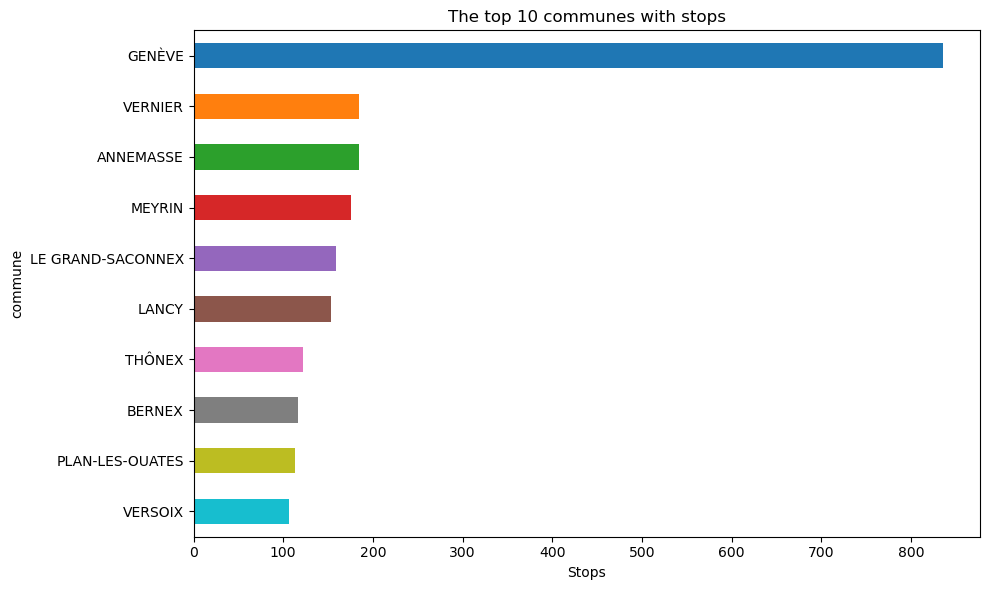

In [4]:
# Municipalities with the most stops:
top_10_communes = stops_df['commune'].value_counts().head(10).reset_index()
top_10_communes.columns = ['commune', 'Arrets_Number']
print(f"Municipalities with the most stops: \n{top_10_communes}"  )

# plot 
colormap = [plt.cm.tab10(i) for i in range(len(top_10_communes))]
bar_plot = top_10_communes.plot.barh(
    x='commune',
    y='Arrets_Number',
    color=colormap,
    legend=False,
    figsize=(10, 6)
)

bar_plot.set_title("The top 10 communes with stops")
bar_plot.set_xlabel("Stops")
bar_plot.invert_yaxis()
plt.tight_layout()
plt.show()


Geneva has significantly more stops than the other municipalities.

Where are the stops located?

In [5]:
#Extraire latitude et longitude depuis coordonnees
#code from chatGPT after debug

import ast
import pandas as pd

# Nettoyer la colonne : convertir les chaînes en dictionnaires
def parse_coord(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return None
    elif isinstance(x, dict):
        return x
    else:
        return None

stops_df['coordonnees'] = stops_df['coordonnees'].apply(parse_coord)

# Extraire latitude et longitude
stops_df['latitude'] = stops_df['coordonnees'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
stops_df['longitude'] = stops_df['coordonnees'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

# Convertir en float (utile si tu veux trier, mapper, etc.)
stops_df['latitude'] = pd.to_numeric(stops_df['latitude'], errors='coerce')
stops_df['longitude'] = pd.to_numeric(stops_df['longitude'], errors='coerce')

# Vérification
print(stops_df[['coordonnees', 'latitude', 'longitude']].head())


                           coordonnees   latitude  longitude
0  {'lon': 6.104478, 'lat': 46.286907}  46.286907   6.104478
1  {'lon': 6.104423, 'lat': 46.287045}  46.287045   6.104423
2   {'lon': 6.092361, 'lat': 46.24374}  46.243740   6.092361
3  {'lon': 6.050063, 'lat': 46.235073}  46.235073   6.050063
4  {'lon': 6.050015, 'lat': 46.234905}  46.234905   6.050015


In [6]:
# install folium
if INSTALL_LIB:
    !pip install folium

Collecting folium  
  Downloading folium-0.19.5-py2.py3-none-any.whl (110 kB)  
     |████████████████████████████████| 110 kB 2.3 MB/s            
Collecting xyzservices  
  Downloading xyzservices-2025.4.0-py3-none-any.whl (90 kB)  
     |████████████████████████████████| 90 kB 2.0 MB/s            
Collecting branca>=0.6.0  
  Downloading branca-0.8.1-py3-none-any.whl (26 kB)  
Requirement already satisfied: jinja2>=2.9 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from folium) (3.1.3)  
Requirement already satisfied: requests in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from folium) (2.26.0)  
Requirement already satisfied: numpy in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from folium) (1.21.5)  
Requirement already satisfied: MarkupSafe>=2.0 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from jinja2>=2.9->folium) (2.1.5)  
Requirement already satisfied: idna<4,>=2.5 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from requests->folium) (3.7)  
Requirement already satisfied: urllib3<1.27,>=1.21.1 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from requests->folium) (1.26.18)  
Requirement already satisfied: certifi>=2017.4.17 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from requests->folium) (2024.2.2)  
Requirement already satisfied: charset-normalizer~=2.0.0 in /home/moi/anaconda3/envs/adsml/lib/python3.9/site-packages (from requests->folium) (2.0.12)  
Installing collected packages: xyzservices, branca, folium  
Successfully installed branca-0.8.1 folium-0.19.5 xyzservices-2025.4.0

ValueError: Location values cannot contain NaNs.  
Folium does not support NaN values, these entries will be filtered out before visualization

In [7]:
stops_df_notNaN = stops_df.dropna(subset=['latitude', 'longitude'])
stops_df_notNaN.shape

(4405, 9)

In [8]:
import folium

# Centrer la carte sur Genève par exemple
carte = folium.Map(location=[46.2, 6.1], zoom_start=12)

# Ajouter les marqueurs pour les 100 premiers arrêts
# for _, row in arrets_df_notNaN.head(100).iterrows():
    
# Ajouter les marqueurs pour tous les arrêts
for _, row in stops_df_notNaN.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['nomarret']
    ).add_to(carte)

# Afficher la carte
carte

The stops are concentrated in the canton of Geneva, with a few located far outside the canton.  

# 2) Passenger counts on line 12 

In [9]:
freq_12_df = pd.read_csv("frequentations_ligne12.csv",sep=",")

display(freq_12_df.head(5))
print(f"We have {freq_12_df.shape[0]} samples and {freq_12_df.shape[1]} columns.")
print(f"The list of columns : \n{freq_12_df.columns.tolist()}")
print(f"\n")
print(f"Information about dataset : \n")
display(freq_12_df.info())
freq_12_df["date"] = pd.to_datetime(freq_12_df["date"])
display(freq_12_df.info())
print(f"\n")
print(f"Sum of null data : \n{freq_12_df.isnull().sum()}")
print(f"\n")
print(f"Sum of duplicate data: {freq_12_df.duplicated().sum()}")      
print(f"\n")

date  ligne ligne_type_act jour_semaine horaire_type       arret  \
0  2025-03-30     12      PRINCIPAL   7-Dimanche     DIMANCHE  Amandolier   
1  2025-03-30     12      PRINCIPAL   7-Dimanche     DIMANCHE    Ancienne   
2  2025-03-30     12      PRINCIPAL   7-Dimanche     DIMANCHE       Armes   
3  2025-03-30     12      PRINCIPAL   7-Dimanche     DIMANCHE     Bel-Air   
4  2025-03-30     12      PRINCIPAL   7-Dimanche     DIMANCHE    De-Staël   

  arret_code_long  indice_semaine  indice_jour_semaine  nb_de_montees  \
0          AMDO00              13                    7         252.87   
1          ANCI01              13                    7         133.37   
2          ARME00              13                    7         801.07   
3          BAIR06              13                    7        1483.25   
4          STAL01              13                    7          81.27   

   nb_de_descentes mois_annee                          coordonnees  \
0           452.56    2025-03  {'lon': 6.168344, 'lat': 46.200043}   
1           387.17    2025-03   {'lon': 6.140731, 'lat': 46.18111}   
2           137.27    2025-03  {'lon': 6.140528, 'lat': 46.186932}   
3          2841.98    2025-03  {'lon': 6.143879, 'lat': 46.203976}   
4            95.32    2025-03   {'lon': 6.132192, 'lat': 46.17588}   

   donnees_definitives  filter_graph  
0                 True         False  
1                 True         False  
2                 True         False  
3                 True         False  
4                 True         False

We have 78349 samples and 15 columns.
The list of columns : 
['date', 'ligne', 'ligne_type_act', 'jour_semaine', 'horaire_type', 'arret', 'arret_code_long', 'indice_semaine', 'indice_jour_semaine', 'nb_de_montees', 'nb_de_descentes', 'mois_annee', 'coordonnees', 'donnees_definitives', 'filter_graph']


Information about dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78349 entries, 0 to 78348
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 78349 non-null  object 
 1   ligne                78349 non-null  int64  
 2   ligne_type_act       78349 non-null  object 
 3   jour_semaine         78349 non-null  object 
 4   horaire_type         78349 non-null  object 
 5   arret                78349 non-null  object 
 6   arret_code_long      78349 non-null  object 
 7   indice_semaine       78349 non-null  int64  
 8   indice_jour_semaine  78349 non-null  int64  
 9   nb

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78349 entries, 0 to 78348
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 78349 non-null  datetime64[ns]
 1   ligne                78349 non-null  int64         
 2   ligne_type_act       78349 non-null  object        
 3   jour_semaine         78349 non-null  object        
 4   horaire_type         78349 non-null  object        
 5   arret                78349 non-null  object        
 6   arret_code_long      78349 non-null  object        
 7   indice_semaine       78349 non-null  int64         
 8   indice_jour_semaine  78349 non-null  int64         
 9   nb_de_montees        78349 non-null  float64       
 10  nb_de_descentes      78349 non-null  float64       
 11  mois_annee           78349 non-null  object        
 12  coordonnees          78349 non-null  object        
 13  donnees_definitives  78349 non-

None



Sum of null data : 
date                   0
ligne                  0
ligne_type_act         0
jour_semaine           0
horaire_type           0
arret                  0
arret_code_long        0
indice_semaine         0
indice_jour_semaine    0
nb_de_montees          0
nb_de_descentes        0
mois_annee             0
coordonnees            0
donnees_definitives    0
filter_graph           0
dtype: int64


Sum of duplicate data: 0




In [10]:
print(f"The data covers the date range from {freq_12_df['date'].min()} to {freq_12_df['date'].max()}")

The data covers the date range from 2021-08-01 00:00:00 to 2025-06-27 00:00:00


In [11]:
freq_12_stops_1 = freq_12_df["arret"].unique()
print(f"The dataset contains {len(freq_12_stops_1)} unique stops. Here is the list: :\n{freq_12_stops_1}")
print(f"There are significantly more stops in the dataset than on the current version of the line.")

The dataset contains 52 unique stops. Here is the list: :
['Amandolier' 'Ancienne' 'Armes' 'Bel-Air' 'De-Staël' 'Grange-Canal'
 'Grange-Falquet' 'Grangettes' 'Lancy-Bachet-Gare' 'Moillesulaz' 'Molard'
 'Peillonnex' 'Place Favre' 'Rive' 'Villereuse' 'Carouge-Rondeau' 'Cirque'
 'Genève-Eaux-Vives-Gare' 'Place de Neuve' 'Plainpalais' "Pont-d'Arve"
 'Pontets' 'Terrassière' 'Augustins' 'Carouge-Marché' 'Graveson' 'Blanche'
 'Trèfle-Blanc' 'Palettes' 'Stand' 'Dépôt Bachet' 'Dépôt Bachet Coursive'
 'Bouchet' 'Lyon' 'Vieusseux' 'Balexert' 'Coutance' 'Gare Cornavin'
 'Mercier' 'Acacias' 'Industrielle' 'Lancy-Piscine' 'Pictet-Thellusson'
 'Lancy-Mairie' 'Uni-Mail' 'Grand-Lancy-Place du 1er-Août'
 'Lancy-Pont-Rouge-Gare/Etoile' 'Poterie' 'Blandonnet' 'Servette'
 'Vernier, Avanchets-Etang' 'Avanchet']
There are significantly more stops in the dataset than on the current version of the line.


In [12]:
freq_12_df["date"] = pd.to_datetime(freq_12_df["date"])

freq_12_stops_date_df = freq_12_df.groupby("arret")["date"].agg(["min", "max"]).reset_index()
freq_12_stops_date_df.columns = ["arret", "date_min", "date_max"]
freq_12_stops_date_df["nb_jours"] = (freq_12_stops_date_df["date_max"] - freq_12_stops_date_df["date_min"]).dt.days + 1

print(freq_12_stops_date_df.head(10))

        arret   date_min   date_max  nb_jours
0     Acacias 2022-10-22 2022-10-30         9
1  Amandolier 2021-08-01 2025-06-27      1427
2    Ancienne 2021-08-01 2025-06-27      1427
3       Armes 2021-08-01 2025-06-27      1427
4   Augustins 2021-08-01 2025-06-27      1427
5    Avanchet 2021-08-01 2024-07-20      1085
6    Balexert 2021-08-01 2024-12-13      1231
7     Bel-Air 2021-08-01 2025-06-27      1427
8     Blanche 2021-08-01 2025-06-27      1427
9  Blandonnet 2021-08-01 2024-12-13      1231


The list of stops on this line evolves over time, and this should be carefully considered in the next steps

For a stop — Bel-Air in the city center — we will look at the evolution of **passenger counts** over the period.  
Since a stop name can have several codes, we need to work with the stop codes. 

In [13]:
stops_df[stops_df["arretcodelong"].isin(['BAIR06', 'BAIR05', 'BAIR18', 'BAIR02'])]

arretcodelong nomarret commune pays  codedidoc  \
124         BAIR06  Bel-Air  GENÈVE   CH  8587387.0   
1656        BAIR02  Bel-Air  GENÈVE   CH  8587387.0   
1657        BAIR05  Bel-Air  GENÈVE   CH  8587387.0   
2964        BAIR18  Bel-Air  GENÈVE   CH  8587387.0   

                              coordonnees actif   latitude  longitude  
124   {'lon': 6.143879, 'lat': 46.203976}     Y  46.203976   6.143879  
1656  {'lon': 6.143449, 'lat': 46.204601}     Y  46.204601   6.143449  
1657  {'lon': 6.144637, 'lat': 46.203716}     Y  46.203716   6.144637  
2964   {'lon': 6.143731, 'lat': 46.20396}     Y  46.203960   6.143731

We will look at the **passenger counts** at a stop (for one code) over time. 

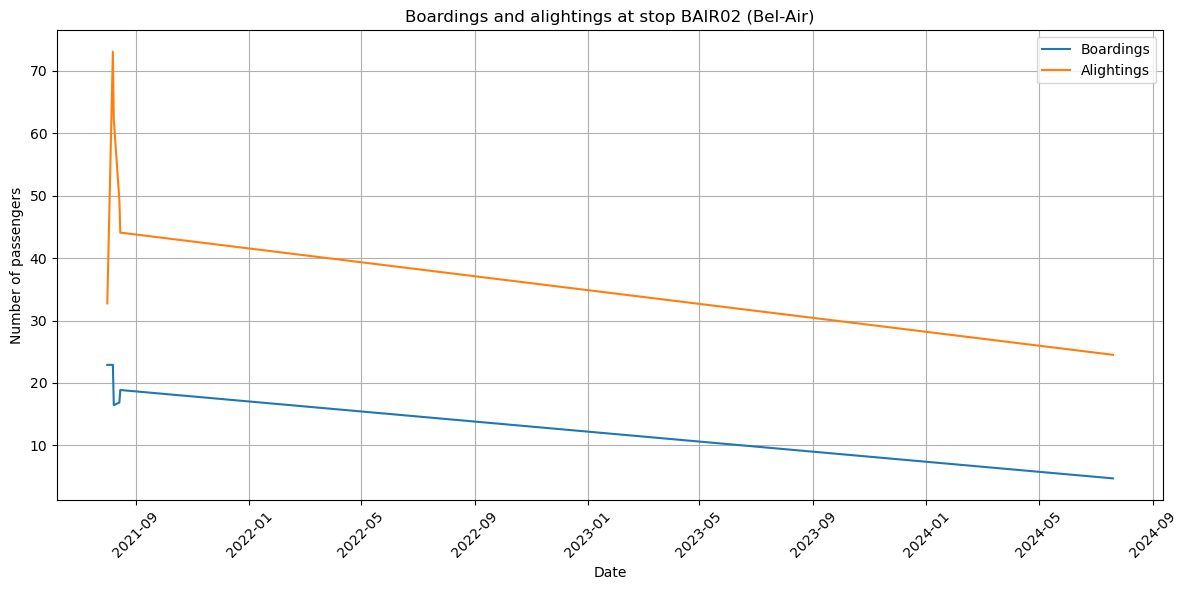

The data is not significant and should be excluded.


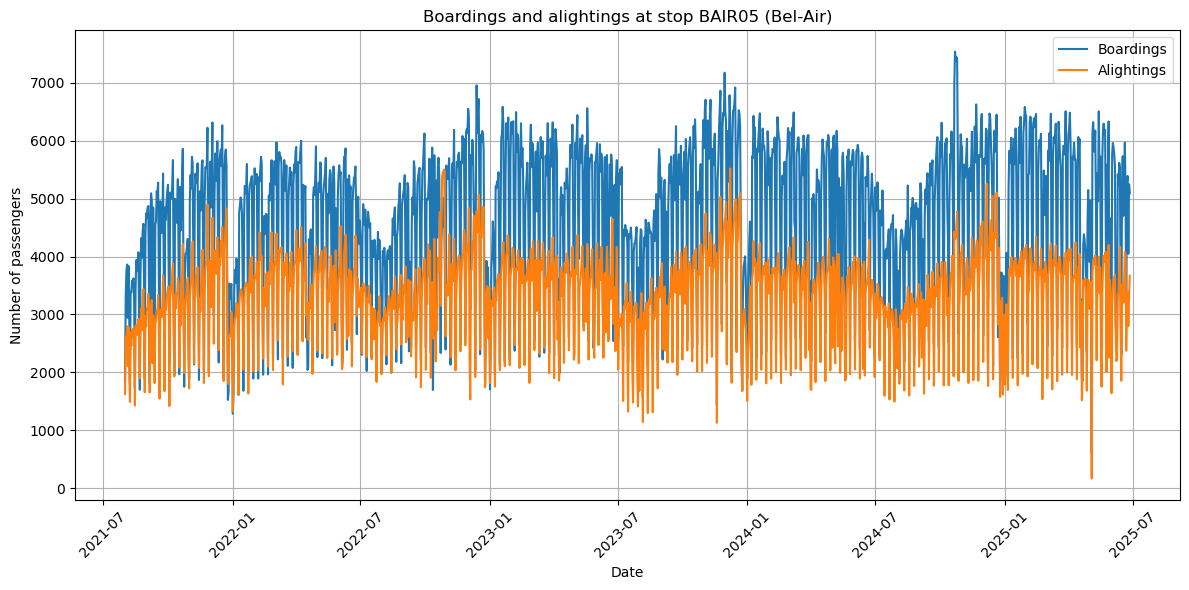

There is a lot of data, with recurring periods, for example: 2021-07 to 2022-01, 2022-07 to 2023-01, 2023-07 to 2024-01.


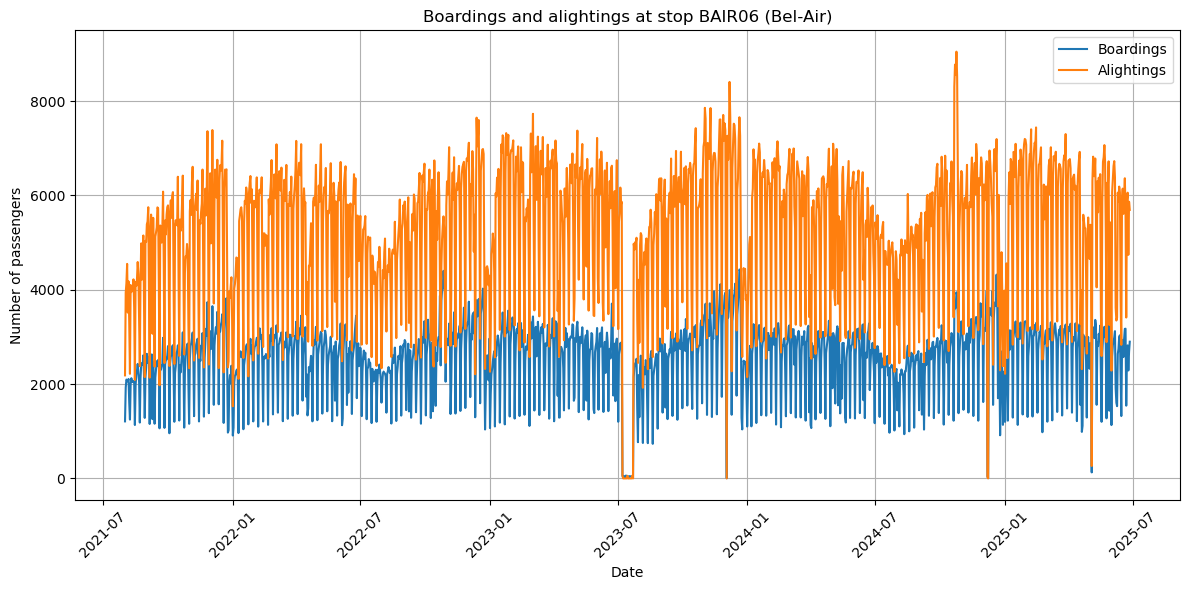

There is a lot of data.


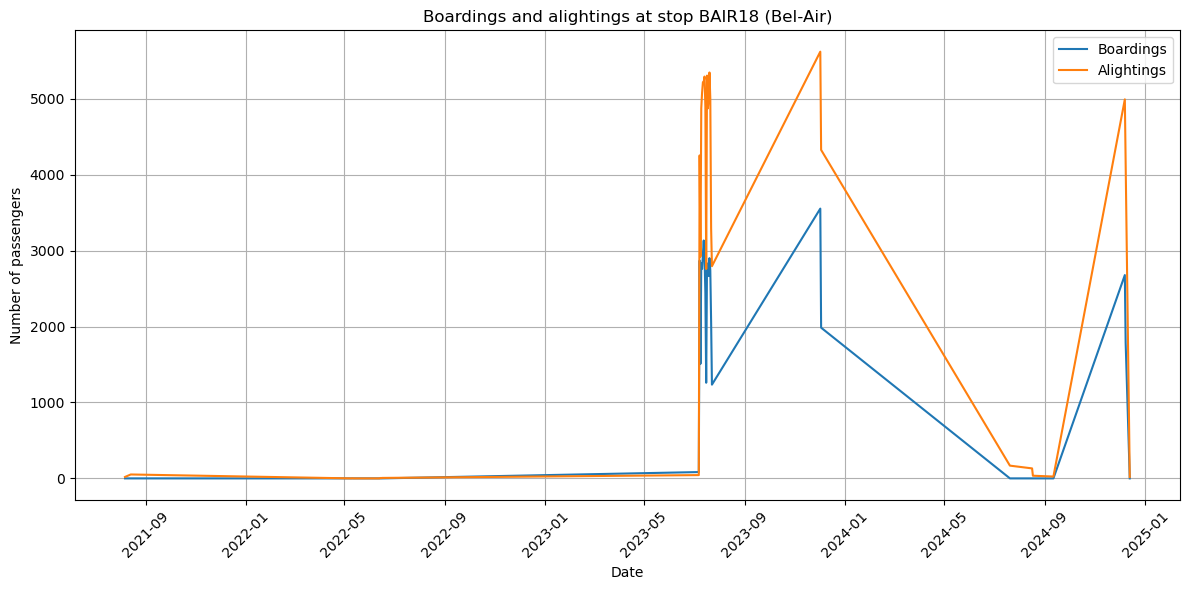

The data is not significant and should be excluded.


In [14]:
def plot_Freq4stop(arret_code):
    arret12_df = freq_12_df[freq_12_df["arret_code_long"]== arret_code]
    #arret12_df.head(5)
    arret12_df = arret12_df.sort_values("date")

    plt.figure(figsize=(12, 6))
    plt.plot(arret12_df["date"], arret12_df["nb_de_montees"], label="Boardings")
    plt.plot(arret12_df["date"], arret12_df["nb_de_descentes"], label="Alightings")
    plt.xlabel("Date")
    plt.ylabel("Number of passengers")
    plt.title(f"Boardings and alightings at stop {arret_code} (Bel-Air)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

arret_code = "BAIR02"
plot_Freq4stop(arret_code)
print("The data is not significant and should be excluded.")

arret_code = "BAIR05"
plot_Freq4stop(arret_code)
print("There is a lot of data, with recurring periods, for example: 2021-07 to 2022-01, 2022-07 to 2023-01, 2023-07 to 2024-01.")

arret_code = "BAIR06"
plot_Freq4stop(arret_code)
print("There is a lot of data.")

arret_code = "BAIR18"
plot_Freq4stop(arret_code)
print("The data is not significant and should be excluded.")



Since some stops have limited data, the number of entries per stop will be counted

record_count
count    120.000000
mean     652.908333
std      689.547556
min        1.000000
25%        9.000000
50%       55.500000
75%     1427.000000
max     1427.000000

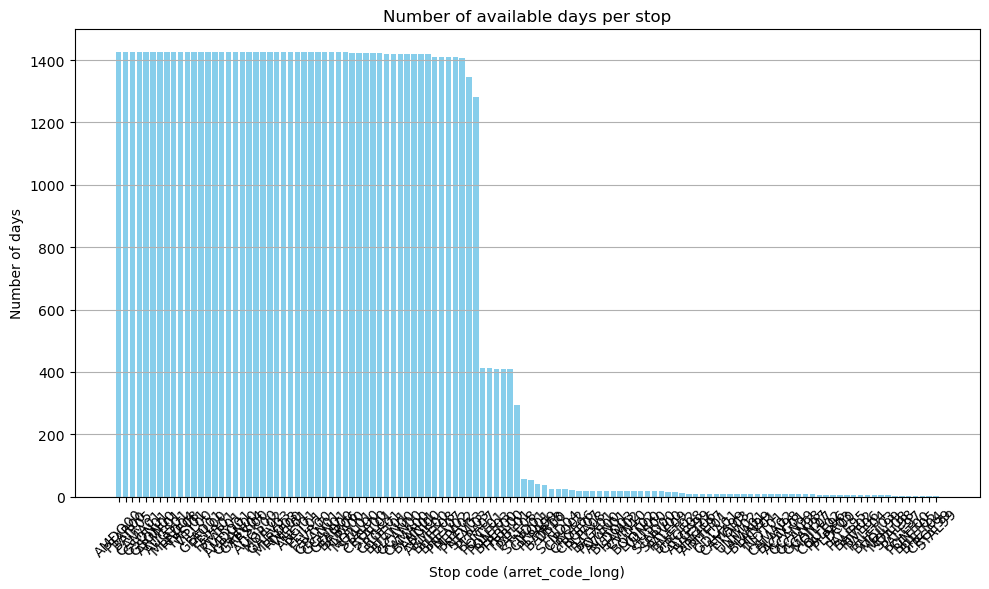

Based on the chart, I will select stops with more than 400 records


arret_code_long  record_count
0          AMDO00          1427
1          PTAR00          1427
2          BAIR05          1427
3          CAMA01          1427
4          GSON01          1427

In [15]:
freq_12_df_stop_c = freq_12_df["arret_code_long"].value_counts().reset_index()
freq_12_df_stop_c.columns = ["arret_code_long", "record_count"]
display(freq_12_df_stop_c.describe())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(freq_12_df_stop_c["arret_code_long"], freq_12_df_stop_c["record_count"], color='skyblue')
plt.xlabel("Stop code (arret_code_long)")
plt.ylabel("Number of days")
plt.title("Number of available days per stop")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis="y")
plt.show()

print("Based on the chart, I will select stops with more than 400 records")
freq_12_df_stop_400 = freq_12_df_stop_c[freq_12_df_stop_c["record_count"] > 400]
freq_12_df_stop_400.head(5)

In our study, we will need to check the operating period of a stop and filter out the stops with a non-significant duration.

# 3) Ridership analysis across all lines

In [16]:
TPG_all_df = pd.read_csv("frequentations_all.csv",sep=",")

print(f"We have {TPG_all_df.shape[0]} samples and {TPG_all_df.shape[1]} columns.")
display(TPG_all_df.head(5))

We have 4874401 samples and 15 columns.


date ligne ligne_type_act jour_semaine horaire_type  \
0  2021-11-03     T           GLCT   3-Mercredi       NORMAL   
1  2021-11-03     T           GLCT   3-Mercredi       NORMAL   
2  2021-11-03     T           GLCT   3-Mercredi       NORMAL   
3  2021-11-04     1      PRINCIPAL      4-Jeudi       NORMAL   
4  2021-11-04     1      PRINCIPAL      4-Jeudi       NORMAL   

               arret arret_code_long  indice_semaine  indice_jour_semaine  \
0  La Plaine-Dne - F          _PLDOF              44                    3   
1     La Plaine-Gare          PLAI00              44                    3   
2             Poizat          POAT01              44                    3   
3        31 Décembre          31DC00              44                    4   
4        31 Décembre          31DC01              44                    4   

   nb_de_montees  nb_de_descentes mois_annee  \
0           0.00             0.45    2021-11   
1          33.33             0.47    2021-11   
2          14.36             0.03    2021-11   
3         397.16           368.51    2021-11   
4         255.15           254.19    2021-11   

                           coordonnees  donnees_definitives  filter_graph  
0  {'lon': 5.991244, 'lat': 46.177319}                 True         False  
1  {'lon': 5.999789, 'lat': 46.178463}                 True         False  
2  {'lon': 5.974564, 'lat': 46.181133}                 True         False  
3  {'lon': 6.161931, 'lat': 46.201679}                 True         False  
4  {'lon': 6.162252, 'lat': 46.201778}                 True         False

In [17]:
print(f"The list of columns : \n{TPG_all_df.columns.tolist()}")
print(f"\n")
print(f"Information about dataset : \n")
display(TPG_all_df.info())

The list of columns : 
['date', 'ligne', 'ligne_type_act', 'jour_semaine', 'horaire_type', 'arret', 'arret_code_long', 'indice_semaine', 'indice_jour_semaine', 'nb_de_montees', 'nb_de_descentes', 'mois_annee', 'coordonnees', 'donnees_definitives', 'filter_graph']


Information about dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874401 entries, 0 to 4874400
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   ligne                object 
 2   ligne_type_act       object 
 3   jour_semaine         object 
 4   horaire_type         object 
 5   arret                object 
 6   arret_code_long      object 
 7   indice_semaine       int64  
 8   indice_jour_semaine  int64  
 9   nb_de_montees        float64
 10  nb_de_descentes      float64
 11  mois_annee           object 
 12  coordonnees          object 
 13  donnees_definitives  bool   
 14  filter_graph         bool   
dtypes: bool(

None

### Observation :   
The Date column is not in the correct format.  

### Action :   
Convert the Date column to date format. 

In [18]:
TPG_all_df['date'] = pd.to_datetime(TPG_all_df['date'])
display(TPG_all_df.info())
print(f"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4874401 entries, 0 to 4874400
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   ligne                object        
 2   ligne_type_act       object        
 3   jour_semaine         object        
 4   horaire_type         object        
 5   arret                object        
 6   arret_code_long      object        
 7   indice_semaine       int64         
 8   indice_jour_semaine  int64         
 9   nb_de_montees        float64       
 10  nb_de_descentes      float64       
 11  mois_annee           object        
 12  coordonnees          object        
 13  donnees_definitives  bool          
 14  filter_graph         bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 492.8+ MB


None

In [19]:
print(f"The data covers the date range from {TPG_all_df['date'].min()} to {TPG_all_df['date'].max()}")

The data covers the date range from 2021-08-01 00:00:00 to 2025-06-22 00:00:00


In [20]:
print(f"Sum of duplicate data: {TPG_all_df.duplicated().sum()}")      
print(f"\n")

Sum of duplicate data: 0




There are no duplicated data.  

In [21]:
print(f"Sum of null data : \n{TPG_all_df.isnull().sum()}")
print(f"\n")

Sum of null data : 
date                       0
ligne                  16129
ligne_type_act             0
jour_semaine               0
horaire_type               0
arret                      0
arret_code_long            0
indice_semaine             0
indice_jour_semaine        0
nb_de_montees              0
nb_de_descentes            0
mois_annee                 0
coordonnees               29
donnees_definitives        0
filter_graph               0
dtype: int64




### Observation :  
There are Null values only in the 'line' and 'coordinates' columns.  
Since I will not use the coordinates from this dataset, the 'coordinates' column can be removed.  

### Action :  
Remove the 'coordinates' column.  

In [22]:
TPG_all_df.drop(columns=['coordonnees'], inplace=True)
print(f"{TPG_all_df.shape}")

(4874401, 14)


In [23]:
print(f"Sum of null data : \n{TPG_all_df.isnull().sum()}")
print(f"\n")

Sum of null data : 
date                       0
ligne                  16129
ligne_type_act             0
jour_semaine               0
horaire_type               0
arret                      0
arret_code_long            0
indice_semaine             0
indice_jour_semaine        0
nb_de_montees              0
nb_de_descentes            0
mois_annee                 0
donnees_definitives        0
filter_graph               0
dtype: int64




For the NaN values in the 'line' column  

In [24]:
TPG_all_df[TPG_all_df['ligne'].isna()].head()

date ligne      ligne_type_act jour_semaine horaire_type  \
2405 2021-11-05   NaN  NOCTAMBUS REGIONAL   5-Vendredi       NORMAL   
2406 2021-11-05   NaN  NOCTAMBUS REGIONAL   5-Vendredi       NORMAL   
2407 2021-11-05   NaN  NOCTAMBUS REGIONAL   5-Vendredi       NORMAL   
2408 2021-11-05   NaN  NOCTAMBUS REGIONAL   5-Vendredi       NORMAL   
2409 2021-11-05   NaN  NOCTAMBUS REGIONAL   5-Vendredi       NORMAL   

                arret arret_code_long  indice_semaine  indice_jour_semaine  \
2405  Balexert-Pailly          PAIL00              44                    5   
2406          Bouchet          BOHT00              44                    5   
2407          Bouchet          BOHT03              44                    5   
2408          Bugnons          BUGN00              44                    5   
2409     CERN-Dne - F          _CERNF              44                    5   

      nb_de_montees  nb_de_descentes mois_annee  donnees_definitives  \
2405            0.0             0.00    2021-11                 True   
2406            0.0             1.11    2021-11                 True   
2407            0.0             0.00    2021-11                 True   
2408           25.5            17.00    2021-11                 True   
2409            0.0             0.00    2021-11                 True   

      filter_graph  
2405         False  
2406         False  
2407         False  
2408         False  
2409         False

In [25]:
16129/4756567*100

0.33908909513941465

### Observation :  
There are 16,129 NaN values out of a total of 4,756,567 rows, which represents 0.33%.  
I choose to remove these rows.  

### Action :  
Remove the rows with null values.  

In [26]:
TPG_all_df.dropna(subset=['ligne'], inplace=True)
print(f"{TPG_all_df.shape}")

(4858272, 14)


In [27]:
print(f"Sum of null data : \n{TPG_all_df.isnull().sum()}")
print(f"\n")

Sum of null data : 
date                   0
ligne                  0
ligne_type_act         0
jour_semaine           0
horaire_type           0
arret                  0
arret_code_long        0
indice_semaine         0
indice_jour_semaine    0
nb_de_montees          0
nb_de_descentes        0
mois_annee             0
donnees_definitives    0
filter_graph           0
dtype: int64




## Exploration of feature content

In [28]:
TPG_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858272 entries, 0 to 4874400
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   ligne                object        
 2   ligne_type_act       object        
 3   jour_semaine         object        
 4   horaire_type         object        
 5   arret                object        
 6   arret_code_long      object        
 7   indice_semaine       int64         
 8   indice_jour_semaine  int64         
 9   nb_de_montees        float64       
 10  nb_de_descentes      float64       
 11  mois_annee           object        
 12  donnees_definitives  bool          
 13  filter_graph         bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 491.1+ MB


### feature :  ligne

In [29]:
#ligne
lignes_unique = TPG_all_df['ligne'].unique()
print(f"Distinct lines: {len(lignes_unique)}")
print(f"List of lines: {lignes_unique}")

ligne_counts = TPG_all_df['ligne'].value_counts()
print("\nNumber of entries per line :")
display(ligne_counts)

Distinct lines: 116
List of lines: ['T' '1' '2' '3' '5' '6' '7' '8' '9' '10' '11' '12' '14' '15' '17' '18'
 '19' '20' '21' '22' '23' '25' '28' '31' '32' '33' '34' '35' '36' '37'
 '38' '39' '41' '42' '43' '44' '45' '46' '47' '48' '50' '51' '52' '53'
 '54' '55' '56' '57' '59' '62' '63' '64' '66' '68' '70' '71' '72' '73'
 '74' '75' '76' '77' '78' '80' '81' '85' '86' '87' '92' '93' '94' '96'
 '97' 'A' 'D' 'E' 'E+' 'F' 'G' 'G+' 'J' 'K' 'L' 'M' 'N' 'NC' 'NE' 'NJ'
 'NK' 'NM' 'NO' 'NP' 'NS' 'NT' 'NV' 'ND' '301' 'C1' 'C3' 'C4' 'C6' 'C8'
 'C5' '82' '91' '60' '67' '61' '69' '83' '302' 'C7' 'C9' '40' '303' '29']

Number of entries per line :


38     123325
17     111182
32     111039
1      109756
22      95838
        ...  
81       1733
97       1434
93       1173
29        686
303        59
Name: ligne, Length: 116, dtype: int64

### Observation :  
Some lines have very few data entries.  

### Action :  
Perform the prediction per stop instead.

### feature :  ligne_type_act

In [30]:
# ligne_type_act
ligne_type_unique = TPG_all_df['ligne_type_act'].unique()
print(f"Distinct ligne type: {len(ligne_type_unique)}")
print(f"List of ligne type: {ligne_type_unique}")

ligne_type_counts = TPG_all_df['ligne_type_act'].value_counts()
print("\nNumber of entries per line type :")
display(ligne_type_counts)

Distinct ligne type: 5
List of ligne type: ['GLCT' 'PRINCIPAL' 'SECONDAIRE' 'SCOLAIRE' 'NOCTAMBUS REGIONAL']

Number of entries per line type :


SECONDAIRE            2379571
PRINCIPAL             1763299
GLCT                   425113
SCOLAIRE               170683
NOCTAMBUS REGIONAL     119606
Name: ligne_type_act, dtype: int64

### feature :  jour_semaine

In [31]:
#jour_semaine
TPG_all_df['jour_semaine'].value_counts()

5-Vendredi    776314
2-Mardi       716141
3-Mercredi    712157
1-Lundi       709724
4-Jeudi       709663
6-Samedi      666209
7-Dimanche    568064
Name: jour_semaine, dtype: int64

### Observation :  
There are fewer data entries for Saturdays and Sundays, which is normal since some lines are not served during the weekend.  
The 'day_of_week' column contains both the day number and the day name.  
Since the day number is already available in the 'week_day_index' column, the 'day_of_week' column is not needed.  

### Action :  
Remove the 'day_of_week' column.  


In [32]:
print(f"Shape before drop: {TPG_all_df.shape}")
TPG_all_df.drop(columns=['jour_semaine'], inplace=True)
print(f"Shape after drop: {TPG_all_df.shape}")

Shape before drop: (4858272, 14)
Shape after drop: (4858272, 13)


### feature :  horaire_type

In [33]:
TPG_all_df['horaire_type'].value_counts()

NORMAL      2760290
VACANCES     786198
SAMEDI       659968
DIMANCHE     651816
Name: horaire_type, dtype: int64

There are fewer data entries on Sundays, which is normal because fewer lines operate.  

### feature :  arret, arret_code_long

In [34]:
TPG_all_df[TPG_all_df['arret'] =='Bel-Air']

date ligne ligne_type_act horaire_type    arret arret_code_long  \
37      2021-11-04     3      PRINCIPAL       NORMAL  Bel-Air          BAIR04   
56      2021-11-04     5      PRINCIPAL       NORMAL  Bel-Air          BAIR00   
215     2021-11-04    17      PRINCIPAL       NORMAL  Bel-Air          BAIR05   
216     2021-11-04    17      PRINCIPAL       NORMAL  Bel-Air          BAIR18   
239     2021-11-04    18      PRINCIPAL       NORMAL  Bel-Air          BAIR18   
...            ...   ...            ...          ...      ...             ...   
4873540 2025-05-10    14      PRINCIPAL       SAMEDI  Bel-Air          BAIR02   
4873588 2025-05-10    17      PRINCIPAL       SAMEDI  Bel-Air          BAIR18   
4873791 2025-06-20     5      PRINCIPAL       NORMAL  Bel-Air          BAIR04   
4874285 2025-05-10    80           GLCT       SAMEDI  Bel-Air          BAIR07   
4874317 2025-05-10    92     SECONDAIRE       SAMEDI  Bel-Air          BAIR05   

         indice_semaine  indice_jour_semaine  nb_de_montees  nb_de_descentes  \
37                   44                    4        1054.21          1315.37   
56                   44                    4         901.88           556.19   
215                  44                    4        3015.72           760.71   
216                  44                    4           0.00            22.12   
239                  44                    4           7.33             0.00   
...                 ...                  ...            ...              ...   
4873540              19                    6        4478.14          6097.94   
4873588              19                    6           0.00           152.62   
4873791              25                    5         503.34          1063.95   
4874285              19                    6         867.07          1268.33   
4874317              19                    6          89.03             2.01   

        mois_annee  donnees_definitives  filter_graph  
37         2021-11                 True         False  
56         2021-11                 True         False  
215        2021-11                 True         False  
216        2021-11                 True         False  
239        2021-11                 True         False  
...            ...                  ...           ...  
4873540    2025-05                False         False  
4873588    2025-05                False         False  
4873791    2025-06                False         False  
4874285    2025-05                False         False  
4874317    2025-05                False         False  

[41988 rows x 13 columns]

### Observation :  
There are several stop codes for a single stop name.  
I will work with stop codes instead of stop names, so the 'arret' column is not needed.  

### Action :  
Remove the 'arret' column. 

In [35]:
print(f"Shape before drop arret : {TPG_all_df.shape}")
TPG_all_df.drop(columns=['arret'], inplace=True)
print(f"Shape after drop: {TPG_all_df.shape}")

Shape before drop arret : (4858272, 13)
Shape after drop: (4858272, 12)


### feature :  mois_annee

In [36]:
TPG_all_df['mois_annee'].sample(8)

3196718    2024-11
869076     2022-10
2975075    2023-05
3987631    2024-12
4187667    2024-12
4208874    2024-09
614077     2022-12
4551750    2025-05
Name: mois_annee, dtype: object

### Observation :  
The column 'mois_annee' contains two pieces of information: the month and the year.  

### Action :  
Split the variable 'mois_annee' into two variables: 'mois' and 'annee'.  

In [37]:
print(f"Shape before split: {TPG_all_df.shape}")
TPG_all_df[['annee', 'mois']] = TPG_all_df['mois_annee'].str.split('-', expand=True) #Expand the split strings into separate columns
TPG_all_df['annee'] = TPG_all_df['annee'].astype(int)
TPG_all_df['mois'] = TPG_all_df['mois'].astype(int)

TPG_all_df.drop(columns=['mois_annee'], inplace=True)
print(f"Shape after split: {TPG_all_df.shape}")

Shape before split: (4858272, 12)
Shape after split: (4858272, 13)


### feature :  donnees_definitive, filter_graph

In [38]:
print(f"{TPG_all_df['donnees_definitives'].unique()}")
print(f"{TPG_all_df['donnees_definitives'].value_counts()}")

print(f"{TPG_all_df['filter_graph'].unique()}")
print(f"{TPG_all_df['filter_graph'].value_counts()}")

[ True False]
True     4684938
False     173334
Name: donnees_definitives, dtype: int64
[False]
False    4858272
Name: filter_graph, dtype: int64


### Observation :  
I will assume that all the data are correct.  

### Action :  
Remove the columns 'donnees_definitive' and 'filter_graph'.  

In [39]:
print(f"Shape before drop: {TPG_all_df.shape}")
TPG_all_df.drop(columns=['donnees_definitives', 'filter_graph'], inplace=True)
print(f"Shape after drop: {TPG_all_df.shape}")

Shape before drop: (4858272, 13)
Shape after drop: (4858272, 11)


### feature :  'nb_de_montees', 'nb_de_descentes'

Features that will be our output: either 'nb_de_montees' or 'nb_de_descentes', depending on the question to address.  

Are there any abnormal values or too few data entries for some cases?  


In [40]:
TPG_all_df[['nb_de_montees', 'nb_de_descentes']].describe().round(2)

nb_de_montees  nb_de_descentes
count     4858272.00       4858272.00
mean          168.90           168.91
std           427.50           424.67
min             0.00             0.00
25%             2.79             3.00
50%            22.29            24.51
75%           136.24           136.75
max          9934.83         10944.99

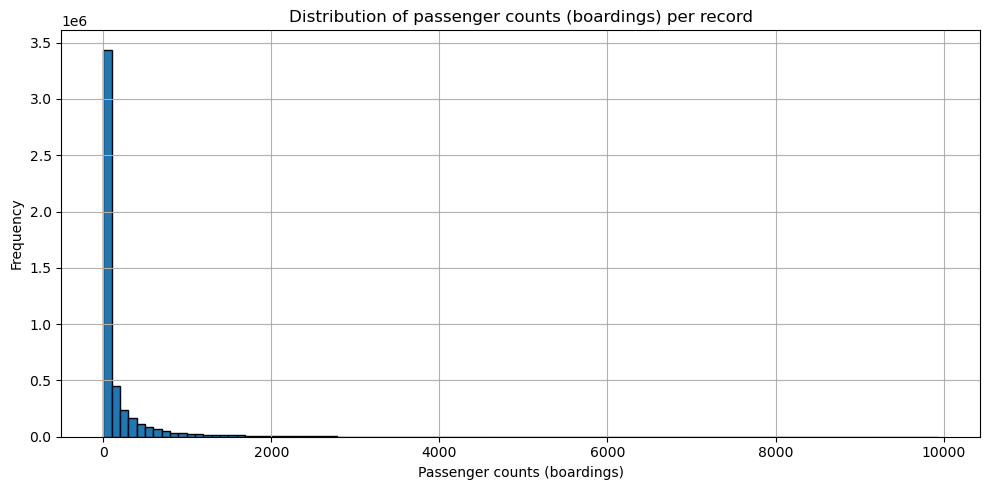

In [41]:
plt.figure(figsize=(10, 5))
TPG_all_df['nb_de_montees'].hist(bins=100, edgecolor='black')
plt.title("Distribution of passenger counts (boardings) per record")
plt.xlabel("Passenger counts (boardings)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Huge concentration of values between 0 and 200 passenger counts (boardings) per record.  
A very long tail (skewed distribution): few cases go beyond 1,000, and even fewer beyond 5,000.  
There are more than 3 million points between 0 and ~200 — showing an over-density of stops with low passenger counts (boardings) or off-peak periods.  


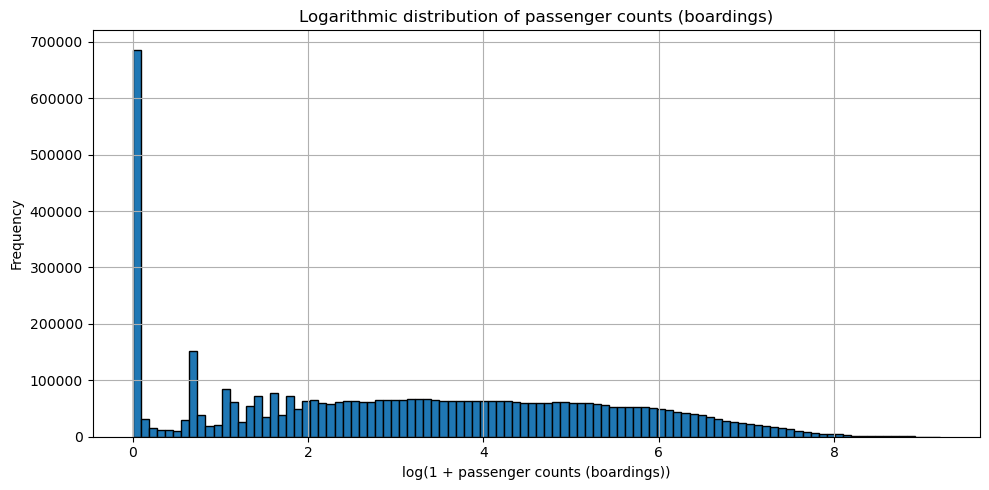

In [42]:
plt.figure(figsize=(10, 5))
plt.hist(np.log1p(TPG_all_df['nb_de_montees']), bins=100, edgecolor='black')
plt.title("Logarithmic distribution of passenger counts (boardings)")
plt.xlabel("log(1 + passenger counts (boardings))")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

### Action :  
Apply a logarithmic transformation to the variables.  

In [43]:
TPG_all_df["log_montees"] = np.log1p(TPG_all_df["nb_de_montees"])
TPG_all_df["log_descentes"] = np.log1p(TPG_all_df["nb_de_descentes"])

## Feature creation

### Passenger counts

In [44]:
# Frequentation totale = montées + descentes
TPG_all_df["frequentation_totale"] = TPG_all_df["nb_de_montees"] + TPG_all_df["nb_de_descentes"]
TPG_all_df["log_frequentation_totale"] = TPG_all_df["log_montees"] + TPG_all_df["log_descentes"]

In [45]:
# delta_montees_descentes = montées - descentes
TPG_all_df["delta_montees_descentes"] = TPG_all_df["nb_de_montees"] - TPG_all_df["nb_de_descentes"]
TPG_all_df["log_delta_montees_descentes"] = TPG_all_df["log_montees"] - TPG_all_df["log_descentes"]

### Vehicle type

We have the column 'ligne_type_act' that provides information about the line type, but it does not indicate which vehicle is used.  
We will check if this information can be completed.  

In [46]:
ligne_type_df = TPG_all_df.groupby("ligne_type_act")["ligne"].unique()
display(ligne_type_df.head())

for type_ligne, lignes in ligne_type_df.items():
    # with chatGPT : Supprimer les NaN, convertir les éléments en str, puis trier
    lignes_sans_nan = [str(l) for l in lignes if pd.notna(l)]
    print(f"{type_ligne} ({len(lignes_sans_nan)} lignes) : {sorted(lignes_sans_nan)}\n")

ligne_type_act
GLCT                    [T, 64, 66, 68, D, F, M, N, 80, 60, 61, 67, 69]
NOCTAMBUS REGIONAL         [NC, NE, NJ, NK, NM, NO, NP, NS, NT, NV, ND]
PRINCIPAL             [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 1...
SCOLAIRE              [80, 81, 85, 87, 92, 93, 94, 96, 97, C1, C3, C...
SECONDAIRE            [31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 4...
Name: ligne, dtype: object

GLCT (13 lignes) : ['60', '61', '64', '66', '67', '68', '69', '80', 'D', 'F', 'M', 'N', 'T']

NOCTAMBUS REGIONAL (11 lignes) : ['NC', 'ND', 'NE', 'NJ', 'NK', 'NM', 'NO', 'NP', 'NS', 'NT', 'NV']

PRINCIPAL (23 lignes) : ['1', '10', '11', '12', '14', '15', '17', '18', '19', '2', '20', '21', '22', '23', '25', '28', '29', '3', '5', '6', '7', '8', '9']

SCOLAIRE (17 lignes) : ['80', '81', '85', '87', '92', '93', '94', '96', '97', 'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

SECONDAIRE (56 lignes) : ['301', '302', '303', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '57', '59', '62', '63', '67', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '82', '83', '86', '91', '92', 'A', 'E', 'E+', 'G', 'G+', 'J', 'K', 'L']



### Observation :  
The category "PRINCIPAL" includes both bus and tram lines.  
As a TPG user, I know the tram line numbers.  
In addition, the TPG website provides a page that categorizes lines by vehicle type:  
https://www.tpg.ch/fr/lignes  

- Tram: 12, 14, 15, 17, 18  
- Trolleybus: 2, 3, 6, 7, 10, 19  
- Bus: 1, 5, 8, 9, 11, 20, 21, 22, 23, 25, 28, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 78, 80, 82, 83, 91, 92, A, E, G, L  
- Express lines: E+, G+  
- Seasonal line: 29  
- Cross-border and partner lines: 271, 272, 274, M, N  

It may be relevant to categorize tram lines separately.  
Since trams and buses have different operational constraints, a dedicated "TRAM" category will be created.  

### Action :  
Create a new variable 'type_vehicule'.  


In [47]:
tram = {"12", "14", "15", "17", "18"}
trolleybus = {"2", "3", "6", "7", "10", "19"}
autobus = {"1","5","8","9","11","20","21","22","23","25","28","31","32","33","34","37","38","39",
           "40","41","42","43","44","45","46","47","48","50","51","52","53","54","55","57","59",
           "60","61","64","66","67","68","69","70","71","72","73","74","75","78","80","82","83",
           "91","92","A","E","G","L"}
lignes_express = {"E+", "G+"}
saisonniere = {"29"}
transfrontalieres = {"271", "272", "274", "M", "N"}

# mapping
def get_type_vehicule(ligne):
    if ligne in tram:
        return "Tram"
    elif ligne in trolleybus:
        return "Trolleybus"
    elif ligne in autobus:
        return "Autobus"
    elif ligne in lignes_express:
        return "Express"
    elif ligne in saisonniere:
        return "Saisonnière"
    elif ligne in transfrontalieres:
        return "Interurbaine"
    else:
        return "Autre"

# Application
TPG_all_df["type_vehicule"] = TPG_all_df["ligne"].apply(get_type_vehicule)

#Check
print(f"Categories in type_vehicule : {TPG_all_df['type_vehicule'].unique()}")
print(TPG_all_df["type_vehicule"].value_counts())

Categories in type_vehicule : ['Autre' 'Autobus' 'Trolleybus' 'Tram' 'Express' 'Interurbaine'
 'Saisonnière']
Autobus         3153705
Autre            681090
Tram             459072
Trolleybus       446538
Express           75215
Interurbaine      41966
Saisonnière         686
Name: type_vehicule, dtype: int64


### Observation :  
There is a majority of bus lines.  

# 4) Weather

In [48]:
# load data from files
meteo_df_daily = pd.read_csv("meteo_daily.csv")
meteo_df_hourly = pd.read_csv("meteo_hourly.csv")

In [49]:
weather_code_dict_fr = {
    0: "Ciel clair",
    1: "Principalement clair",
    2: "Partiellement nuageux",
    3: "Couvert",
    45: "Brouillard",
    48: "Brouillard avec givre",
    51: "Bruine légère",
    53: "Bruine modérée",
    55: "Bruine dense",
    56: "Bruine verglaçante légère",
    57: "Bruine verglaçante dense",
    61: "Pluie faible",
    63: "Pluie modérée",
    65: "Pluie forte",
    66: "Pluie verglaçante légère",
    67: "Pluie verglaçante forte",
    71: "Chute de neige faible",
    73: "Chute de neige modérée",
    75: "Chute de neige forte",
    77: "Grains de neige",
    80: "Averses légères",
    81: "Averses modérées",
    82: "Averses violentes",
    85: "Averses de neige légères",
    86: "Averses de neige fortes",
    95: "Orage léger ou modéré",
    96: "Orage avec grêle légère",
    99: "Orage avec grêle forte"
}

weather_code_dict = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snow fall",
    73: "Moderate snow fall",
    75: "Heavy snow fall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm: Slight or moderate",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}

In [50]:

meteo_df_daily['time'] = pd.to_datetime(meteo_df_daily['time'])
meteo_df_hourly['time'] = pd.to_datetime(meteo_df_hourly['time'])

# meteo_df_hourly["weather_description"] = meteo_df_hourly["weather_code"].map(weather_code_dict)
# meteo_df_daily["weather_description"] = meteo_df_daily["weather_code"].map(weather_code_dict)


In [51]:
display(meteo_df_daily.head(5))
display(meteo_df_hourly.head(5))

print(f"The data covers the date range from {meteo_df_daily['time'].min()} to {meteo_df_daily['time'].max()}")

time  weather_code
0 2021-08-01            63
1 2021-08-02            51
2 2021-08-03            61
3 2021-08-04            61
4 2021-08-05            53

time  temperature_2m  precipitation  weather_code  \
0 2021-08-01 00:00:00            17.5            0.5            53   
1 2021-08-01 01:00:00            17.1            0.3            51   
2 2021-08-01 02:00:00            16.2            0.4            51   
3 2021-08-01 03:00:00            15.7            0.5            53   
4 2021-08-01 04:00:00            15.5            0.2            51   

   wind_speed_10m  
0             2.0  
1             2.1  
2             2.9  
3             1.8  
4             3.1

The data covers the date range from 2021-08-01 00:00:00 to 2025-06-22 00:00:00


The data covers the time period of boardings.

The analysis will focus on daily weather data

In [52]:
print(f"We have {meteo_df_daily.shape[0]} samples and {meteo_df_daily.shape[1]} columns.")
print(f"The list of columns : \n{meteo_df_daily.columns.tolist()}")
print(f"\n")
print(f"Information about dataset : \n")
display(meteo_df_daily.info())
print(f"\n")
print(f"Sum of null data : \n{meteo_df_daily.isnull().sum()}")
print(f"\n")
print(f"Sum of duplicate data: {meteo_df_daily.duplicated().sum()}")      
print(f"\n")

We have 1422 samples and 2 columns.
The list of columns : 
['time', 'weather_code']


Information about dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          1422 non-null   datetime64[ns]
 1   weather_code  1422 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.3 KB


None



Sum of null data : 
time            0
weather_code    0
dtype: int64


Sum of duplicate data: 0




# 5) Merging TPG and weather datasets

In [53]:
meteo_df_daily = meteo_df_daily.rename(columns={"time": "date"})
TPG_meteo_all_df = TPG_all_df.merge(meteo_df_daily, on="date", how="left")
print(TPG_meteo_all_df.info())
display(TPG_meteo_all_df.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858272 entries, 0 to 4858271
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   ligne                        object        
 2   ligne_type_act               object        
 3   horaire_type                 object        
 4   arret_code_long              object        
 5   indice_semaine               int64         
 6   indice_jour_semaine          int64         
 7   nb_de_montees                float64       
 8   nb_de_descentes              float64       
 9   annee                        int64         
 10  mois                         int64         
 11  log_montees                  float64       
 12  log_descentes                float64       
 13  frequentation_totale         float64       
 14  log_frequentation_totale     float64       
 15  delta_montees_descentes      float64       
 16  

date ligne ligne_type_act horaire_type arret_code_long  \
0 2021-11-03     T           GLCT       NORMAL          _PLDOF   
1 2021-11-03     T           GLCT       NORMAL          PLAI00   
2 2021-11-03     T           GLCT       NORMAL          POAT01   
3 2021-11-04     1      PRINCIPAL       NORMAL          31DC00   
4 2021-11-04     1      PRINCIPAL       NORMAL          31DC01   

   indice_semaine  indice_jour_semaine  nb_de_montees  nb_de_descentes  annee  \
0              44                    3           0.00             0.45   2021   
1              44                    3          33.33             0.47   2021   
2              44                    3          14.36             0.03   2021   
3              44                    4         397.16           368.51   2021   
4              44                    4         255.15           254.19   2021   

   mois  log_montees  log_descentes  frequentation_totale  \
0    11     0.000000       0.371564                  0.45   
1    11     3.536020       0.385262                 33.80   
2    11     2.731767       0.029559                 14.39   
3    11     5.986854       5.912178                765.67   
4    11     5.545763       5.542008                509.34   

   log_frequentation_totale  delta_montees_descentes  \
0                  0.371564                    -0.45   
1                  3.921282                    32.86   
2                  2.761326                    14.33   
3                 11.899032                    28.65   
4                 11.087772                     0.96   

   log_delta_montees_descentes type_vehicule  weather_code  
0                    -0.371564         Autre            63  
1                     3.150757         Autre            63  
2                     2.702208         Autre            63  
3                     0.074676       Autobus            53  
4                     0.003755       Autobus            53

# 6) Summary of the EDA

In [54]:
TPG_meteo_all_df.isna().sum()

date                           0
ligne                          0
ligne_type_act                 0
horaire_type                   0
arret_code_long                0
indice_semaine                 0
indice_jour_semaine            0
nb_de_montees                  0
nb_de_descentes                0
annee                          0
mois                           0
log_montees                    0
log_descentes                  0
frequentation_totale           0
log_frequentation_totale       0
delta_montees_descentes        0
log_delta_montees_descentes    0
type_vehicule                  0
weather_code                   0
dtype: int64

In [55]:
TPG_meteo_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4858272 entries, 0 to 4858271
Data columns (total 19 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   date                         datetime64[ns]
 1   ligne                        object        
 2   ligne_type_act               object        
 3   horaire_type                 object        
 4   arret_code_long              object        
 5   indice_semaine               int64         
 6   indice_jour_semaine          int64         
 7   nb_de_montees                float64       
 8   nb_de_descentes              float64       
 9   annee                        int64         
 10  mois                         int64         
 11  log_montees                  float64       
 12  log_descentes                float64       
 13  frequentation_totale         float64       
 14  log_frequentation_totale     float64       
 15  delta_montees_descentes      float64       
 16  

In [56]:
#Save the dataset

file_name = "TPG_meteo_all_df.csv"
TPG_meteo_all_df.to_csv(file_name, index=False)

## (b) How does the EDA inform your project plan?

I have a clean initial dataset: no duplicates and very few missing values.  
I observed that some features are not useful (for example: 'filter_graph') or redundant ('jour_semaine'), so I removed them.  
I also noticed that the distribution of passenger counts (boardings) and passenger counts (alightings) is highly skewed.  
A logarithmic transformation can help the models by reducing this skewness.  
Based on this, I created new variables: the sum of passenger counts (boardings) and passenger counts (alightings) to represent the total ridership, and the difference between them to provide insights into passenger flows.  

## (c) What further EDA do you plan for project?

I will look more closely at the validity of the data over time:  
* operating duration of stops,  
* which stops have the highest passenger counts,  
* temporal analysis of the data: checking if there are recurring or similar patterns over time.      

In [57]:
#end